<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/COMPAS_data_inspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
import os

# Specify the directory path
directory_path = '//Users/mirthedankloff/Documents/XAI_Bias_Error/COMPAS'

# Traverse the directory and print the names of all files
for dirname, _, filenames in os.walk(directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


LOAD COMPAS data

In [69]:
compas_s = pd.read_csv("/content/final_preprocessed_compas(2).csv")
ofercompas = pd.read_csv("/content/propublica_data_for_fairml.csv")
originalcompas = pd.read_csv("/content/compas-scores-two-years-violent.csv")
cox_violent_filt = pd.read_csv('/content/cox-violent-parsed_filt.csv')

In [70]:
target = "Two_yr_Recidivism"
X = ofercompas.drop([target],axis=1)
Y = ofercompas[target]
age = originalcompas['age']

TRAIN  Model

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True, stratify = Y)

model = RandomForestClassifier()
model.fit(X_train, Y_train)

#predictions
Yhat = model.predict(X_test)
len(Yhat)


1852

COLLECT the errors

In [72]:
predictions = pd.DataFrame()
predictions['predicted_class'] = Yhat.tolist()
predictions = predictions.set_index(X_test.index)
predictions['true_class'] = Y_test

#accuracy
accuracy = accuracy_score(predictions['true_class'], predictions['predicted_class'])
print(f"Accuracy: {accuracy:.4f}")

#confusion matrix
cm = confusion_matrix(predictions['true_class'], predictions['predicted_class'])
print(cm)



Accuracy: 0.6658
[[764 245]
 [374 469]]


In [73]:
predictions['errors'] = abs(predictions['predicted_class'] - predictions['true_class'])
predictions['errors'] = predictions['errors'].replace(2.0, 1.0)


data_pred = X_test.merge(predictions, how= 'outer', left_index = True, right_index = True)

errors = data_pred['errors']
ofercompas_out = data_pred.drop(['predicted_class', 'true_class', 'errors'], axis=1)

display(data_pred.columns)
print(len(data_pred))
data_pred[data_pred['errors']==1]

Index(['Number_of_Priors', 'score_factor', 'Age_Above_FourtyFive',
       'Age_Below_TwentyFive', 'African_American', 'Asian', 'Hispanic',
       'Native_American', 'Other', 'Female', 'Misdemeanor', 'predicted_class',
       'true_class', 'errors'],
      dtype='object')

1852


,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,predicted_class,true_class,errors
1618,1,1,0,1,0,0,1,0,0,0,1,0,1,1
3944,0,0,0,0,0,0,1,0,0,0,1,0,1,1
5765,14,0,1,0,1,0,0,0,0,0,1,1,0,1
5539,12,1,1,0,1,0,0,0,0,0,1,1,0,1
4568,1,1,0,1,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,0,0,0,0,1,0,0,0,0,0,0,0,1,1
4609,17,1,0,0,1,0,0,0,0,0,1,1,0,1
3063,5,0,0,0,0,0,0,0,0,0,0,1,0,1
248,5,0,0,0,1,0,0,0,0,0,0,0,1,1


Selecting 4 labels (FP, FN, TP, TN)

In [74]:
def get_error_type(row):
    true_class = row['true_class']
    predicted_class = row['predicted_class']

    if true_class == predicted_class and true_class == 1:
        row['TP'] = 1
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 0
    elif true_class == predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 1
        row['FN'] = 0
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 1:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 1
        row['FP'] = 0
    elif true_class != predicted_class and true_class == 0:
        row['TP'] = 0
        row['TN'] = 0
        row['FN'] = 0
        row['FP'] = 1

    return row

#apply function to rows in data
data_pred = data_pred.apply(get_error_type, axis=1)

#print(data_pred.columns)
print(data_pred)

      Number_of_Priors  score_factor  Age_Above_FourtyFive  \
3553                 3             1                     1   
2814                 1             1                     0   
2521                 2             0                     1   
3784                 0             0                     0   
4824                 4             1                     0   
...                ...           ...                   ...   
2944                 0             1                     0   
283                  0             0                     0   
3333                 0             0                     1   
248                  5             0                     0   
1954                 3             1                     0   

      Age_Below_TwentyFive  African_American  Asian  Hispanic  \
3553                     0                 1      0         0   
2814                     1                 1      0         0   
2521                     0                 0      0         

Scatterplot 4 labels (TP, FP, FN, TN) --> discrete variable problem. Scatterplotted on cox_violent_parsed_filt dataset

Index(['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race',
       'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'priors_count.1', 'event'],
      dtype='object')

Text(0.5, 0, 'age')

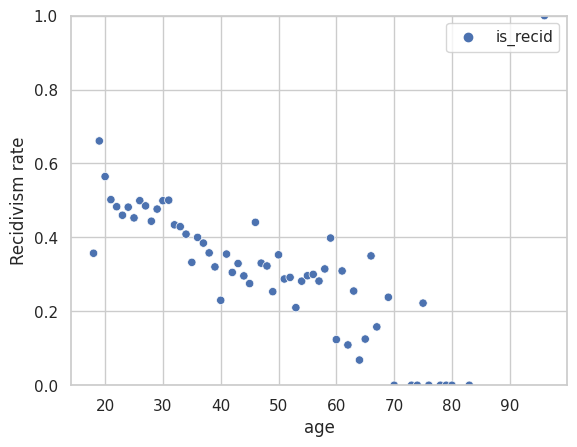

In [75]:
display(cox_violent_filt.columns)
d = cox_violent_filt.groupby('age').agg({'is_recid':'mean'})
#d = cox_violent_filt.groupby('age').agg({'FP'})

sns.scatterplot(data=d);
plt.ylim(0,1);
plt.ylabel('Recidivism rate')
plt.xlabel('age')



Barchart 4 labels (FP, FN, TP, TN)

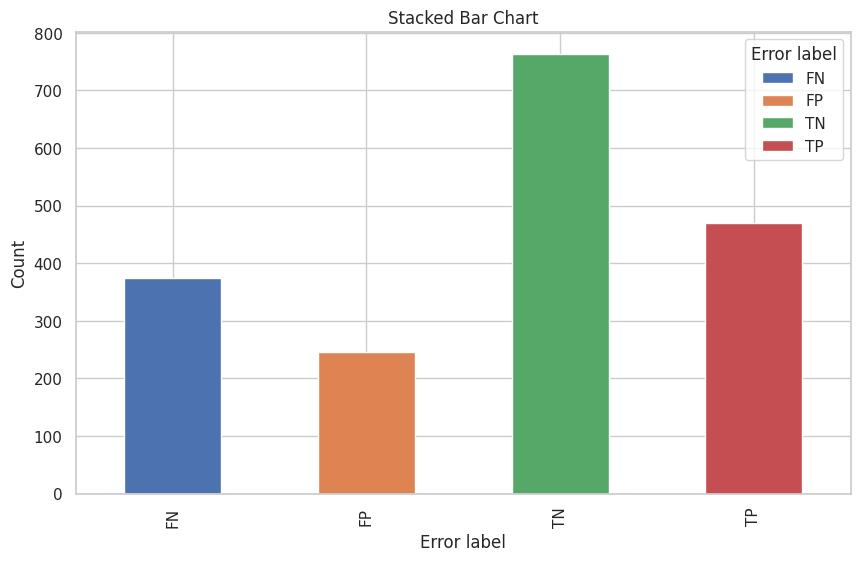

In [76]:
errors_df = data_pred[['TP', 'FP', 'FN', 'TN']]

# Melt the DataFrame for easy plotting
melted_df = pd.melt(errors_df, var_name='Error label', value_name='Count')

# Pivot the DataFrame for stacked bar chart
pivot_df = melted_df.pivot_table(index='Error label', columns='Error label', values='Count', aggfunc='sum', fill_value=0)

# Plot the stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# Add labels and title
plt.xlabel('Error label')
plt.ylabel('Count')
plt.title('Stacked Bar Chart')

# Show the plot
plt.show()




Change dummy's to categorical for boxplots etc.

In [88]:
#Chaning and adding the demographics as a categorical
# df for demographics
demo = data_pred[['African_American', 'Asian', 'Hispanic', 'Native_American', 'Other']]

# convert dummy demo to categorical
demo['Demographic_Group'] = demo.idxmax(axis=1)

# add to dataset
data_all = data_pred.merge(demo, how="inner")

# drop original dummy columns
data_all.drop(['African_American', 'Asian', 'Hispanic', 'Native_American', 'Other'], axis=1, inplace=True)

print(data_all)

         Number_of_Priors  score_factor  Age_Above_FourtyFive  \
0                       3             1                     1   
1                       3             1                     1   
2                       3             1                     1   
3                       3             1                     1   
4                       3             1                     1   
...                   ...           ...                   ...   
1308769                 0             0                     0   
1308770                 1             1                     0   
1308771                 1             1                     0   
1308772                15             1                     1   
1308773                15             1                     1   

         Age_Below_TwentyFive  Female  Misdemeanor  predicted_class  \
0                           0       0            0                1   
1                           0       0            0                1   
2     

In [ ]:
#Changing and adding the demographics as a categorical
# df for errors
demo = data_pred[['African_American', 'Asian', 'Hispanic', 'Native_American', 'Other']]

# convert dummy demo to categorical
demo['Demographic_Group'] = demo.idxmax(axis=1)

# add to dataset
data_all = data_pred.merge(demo, how="inner")

# drop original dummy columns
data_all.drop(['African_American', 'Asian', 'Hispanic', 'Native_American', 'Other'], axis=1, inplace=True)

print(data_all)

Barchart 4 labels per demographic group

Index(['Number_of_Priors', 'score_factor', 'Age_Above_FourtyFive',
       'Age_Below_TwentyFive', 'African_American', 'Asian', 'Hispanic',
       'Native_American', 'Other', 'Female', 'Misdemeanor', 'predicted_class',
       'true_class', 'errors', 'TP', 'TN', 'FN', 'FP'],
      dtype='object')